# Building Machine Learning Systems with Python

In [1]:
import sys
sys.version

'3.10.5 (main, Jun  6 2022, 18:49:26) [GCC 12.1.0]'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Iris Dataset

In [4]:
from sklearn.datasets import load_iris
data = load_iris()

features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names
labels = target_names[target]

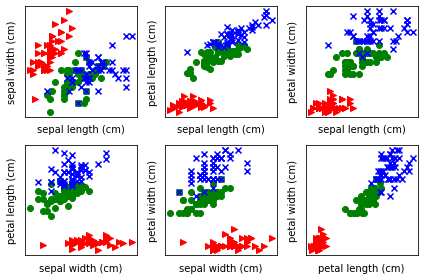

In [6]:
fig,axes = plt.subplots(2, 3)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
    ('r', '>'),
    ('g', 'o'),
    ('b', 'x'),
]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[
                    target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

Learning a classification model (a decision tree):

In [7]:
from sklearn import tree

tr = tree.DecisionTreeClassifier(min_samples_leaf=10)
tr.fit(features, labels)

DecisionTreeClassifier(min_samples_leaf=10)

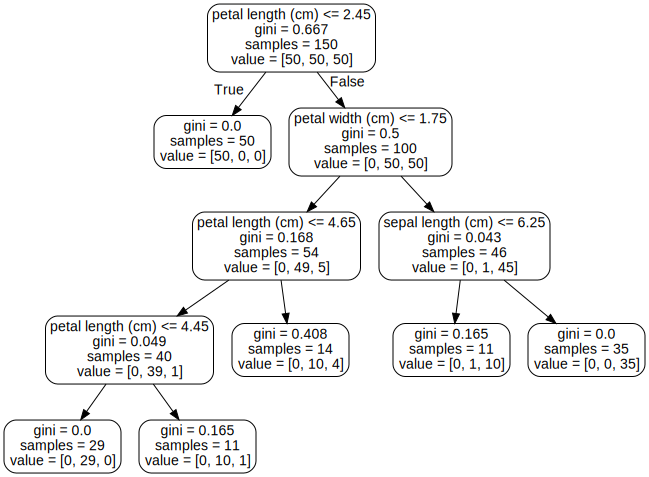

In [8]:
import graphviz
tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file='decision.dot')

graphviz.Source(open('decision.dot').read())

In [9]:
prediction = tr.predict(features)
print("Accuracy: {:.1%}".format(np.mean(prediction == labels)))

Accuracy: 96.0%


In [12]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

print("Accuracy (with LOO CV): {:.1%}".format(np.mean(predictions.ravel() == labels)))

Accuracy (with LOO CV): 95.3%


In [13]:
from sklearn import model_selection

predictions = model_selection.cross_val_predict(
    tr,
    features,
    labels,
    cv=model_selection.LeaveOneOut())
print(np.mean(predictions == labels))

0.9533333333333334


## The seeds dataset

In [14]:
import numpy as np


def load_dataset(dataset_name):
    '''
    data = load_dataset(dataset_name)
    Load a given dataset
    Returns
    -------
    data : dictionary
    '''
    features = []
    target = []
    target_names = set()
    with open('./data/{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            features.append([float(tk) for tk in tokens[:-1]])
            target.append(tokens[-1])
            target_names.add(tokens[-1])
    features = np.array(features)

    target_names = list(target_names)
    target_names.sort()
    target = np.array([target_names.index(t) for t in target])
    return {
            'features': features,
            'target_names': target_names,
            'target': target,
    }

In [15]:
feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
data = load_dataset('seeds')
features = data['features']
target = data['target']

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

kf = model_selection.KFold(n_splits=5, shuffle=False)
means = []
for training,testing in kf.split(features):
   # We learn a model for this fold with `fit` and then apply it to the
   # testing data with `predict`:
   knn.fit(features[training], target[training])
   prediction = knn.predict(features[testing])

   # np.mean on an array of booleans returns fraction
 # of correct decisions for this fold:
   curmean = np.mean(prediction == target[testing])
   means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=5)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

means = []
for training,testing in kf.split(features):
    # We learn a model for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    classifier.fit(features[training], target[training])
    prediction = classifier.predict(features[testing])

    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 83.8%
Mean accuracy: 86.7%


In [17]:
def plot_decision_space(clf, features, target, use_color=True):
    from matplotlib.colors import ListedColormap

    clf.fit(features[:, [0,2]], target)

    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)
    C = clf.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if use_color:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])

    fig,ax = plt.subplots()
    ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
    for lab, ma in zip(range(3), "Do^"):
        ax.plot(features[target == lab, 0], features[
                 target == lab, 2], ma, c=(1., 1., 1.), ms=6)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    return fig

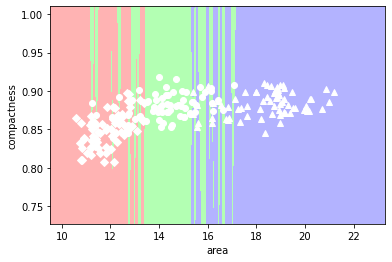

In [18]:
_ = plot_decision_space(knn, features, target)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()),
                       ('knn', classifier)])

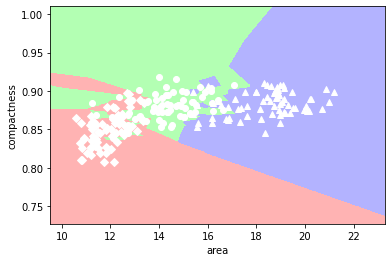

In [22]:
_ = plot_decision_space(classifier, features, target)

## Random Forest

In [24]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100)
predict = model_selection.cross_val_predict(rf, features, target)
print("RF accuracy: {:.1%}".format(np.mean(predict == target)))

RF accuracy: 89.0%


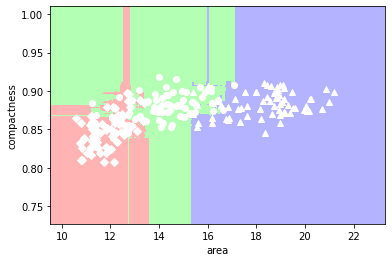

In [26]:
_ = plot_decision_space(rf, features, target)